In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm


In [24]:
import os
from pathlib import Path
from PIL import Image, UnidentifiedImageError

class CaptchaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.image_paths = list(self.image_dir.glob("*.png"))
        self.valid_image_paths = []

        for img_path in self.image_paths:
            try:
                Image.open(img_path).verify()
                self.valid_image_paths.append(img_path)
            except (UnidentifiedImageError, IOError):
                print(f"Skipping corrupted file: {img_path}")

        self.transform = transform
        self.seq_length = 5
        self.alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
        self.char_to_idx = {char: idx for idx, char in enumerate(self.alphabet)}

    def __len__(self):
        return len(self.valid_image_paths)

    def __getitem__(self, idx):
        img_path = self.valid_image_paths[idx]
        image = Image.open(img_path).convert("L")
        label = img_path.stem

        if self.transform:
            image = self.transform(image)

        # Encode the label
        encoded_label = np.zeros((self.seq_length, len(self.alphabet)))
        for pos, char in enumerate(label):
            encoded_label[pos, self.char_to_idx[char]] = 1
        encoded_label = encoded_label.flatten()

        return image, torch.tensor(encoded_label, dtype=torch.float32)


In [25]:
# Define CNN Model
class CaptchaCNN(nn.Module):
    def __init__(self):
        super(CaptchaCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Adjust output layer to match the alphabet size * sequence length
        self.fc_layers = nn.Sequential(
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 62 * 5)  # Output size for 62 chars (a-z, A-Z, 0-9) * 5 characters
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [26]:
# Training and validation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in tqdm(data_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
    return total_loss / len(data_loader.dataset)

def validate_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            predicted = (outputs.view(-1, 62, 5).argmax(dim=1) == labels.view(-1, 62, 5).argmax(dim=1)).sum().item()
            total_predictions += labels.size(0) * 5
            correct_predictions += predicted
    
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [27]:
# Main script
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_dir = "/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset"
    
    transform = transforms.Compose([
        transforms.Resize((64, 128)),  # Resize images to a uniform size
        transforms.ToTensor()
    ])
    
    dataset = CaptchaDataset(data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    model = CaptchaCNN().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    num_epochs = 70
    best_accuracy = 0.0
    best_model_path = "best_captcha_model.pth"
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate_epoch(model, val_loader, loss_fn, device)
        
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_accuracy:.4f}")

In [28]:
if __name__ == "__main__":
    main()

Skipping corrupted file: /kaggle/input/large-captcha-dataset/Large_Captcha_Dataset/4q2wA.png
Epoch 1/70


Train Loss: 0.0836, Validation Loss: 0.0788, Validation Accuracy: 0.0374
New best model saved with accuracy: 0.0374
Epoch 2/70


Train Loss: 0.0803, Validation Loss: 0.0747, Validation Accuracy: 0.0852
New best model saved with accuracy: 0.0852
Epoch 3/70


Train Loss: 0.0753, Validation Loss: 0.0670, Validation Accuracy: 0.1688
New best model saved with accuracy: 0.1688
Epoch 4/70


Train Loss: 0.0674, Validation Loss: 0.0561, Validation Accuracy: 0.2584
New best model saved with accuracy: 0.2584
Epoch 5/70


Train Loss: 0.0569, Validation Loss: 0.0485, Validation Accuracy: 0.3081
New best model saved with accuracy: 0.3081
Epoch 6/70


Train Loss: 0.0388, Validation Loss: 0.0422, Validation Accuracy: 0.3896
New best model saved with accuracy: 0.3896
Epoch 8/70


Train Loss: 0.0334, Validation Loss: 0.0266, Validation Accuracy: 0.4478
New best model saved with accuracy: 0.4478
Epoch 9/70


Train Loss: 0.0290, Validation Loss: 0.0248, Validation Accuracy: 0.4613
New best model saved with accuracy: 0.4613
Epoch 10/70


Train Loss: 0.0253, Validation Loss: 0.0210, Validation Accuracy: 0.4827
New best model saved with accuracy: 0.4827
Epoch 11/70


Train Loss: 0.0227, Validation Loss: 0.0191, Validation Accuracy: 0.5029
New best model saved with accuracy: 0.5029
Epoch 12/70


Train Loss: 0.0198, Validation Loss: 0.0177, Validation Accuracy: 0.5143
New best model saved with accuracy: 0.5143
Epoch 14/70


Training:  66%|██████▌   | 1364/2059 [02:36<01:38,  7.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Loss: 0.0182, Validation Loss: 0.0246, Validation Accuracy: 0.4815
Epoch 16/70


Train Loss: 0.0176, Validation Loss: 0.0144, Validation Accuracy: 0.5205
New best model saved with accuracy: 0.5205
Epoch 17/70


Train Loss: 0.0171, Validation Loss: 0.0149, Validation Accuracy: 0.5228
New best model saved with accuracy: 0.5228
Epoch 18/70


Train Loss: 0.0167, Validation Loss: 0.0162, Validation Accuracy: 0.5100
Epoch 19/70


Train Loss: 0.0164, Validation Loss: 0.0136, Validation Accuracy: 0.5192
Epoch 20/70


Train Loss: 0.0161, Validation Loss: 0.0153, Validation Accuracy: 0.5177
Epoch 21/70


Train Loss: 0.0159, Validation Loss: 0.0158, Validation Accuracy: 0.5150
Epoch 22/70


Train Loss: 0.0156, Validation Loss: 0.0136, Validation Accuracy: 0.5158
Epoch 23/70


Train Loss: 0.0154, Validation Loss: 0.0146, Validation Accuracy: 0.5260
New best model saved with accuracy: 0.5260
Epoch 24/70


Train Loss: 0.0153, Validation Loss: 0.0272, Validation Accuracy: 0.4943
Epoch 25/70


KeyboardInterrupt: 

/tmp/ipykernel_30/2015308988.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_captcha_model.pth"))


Skipping corrupted file: /kaggle/input/large-captcha-dataset/Large_Captcha_Dataset/4q2wA.png


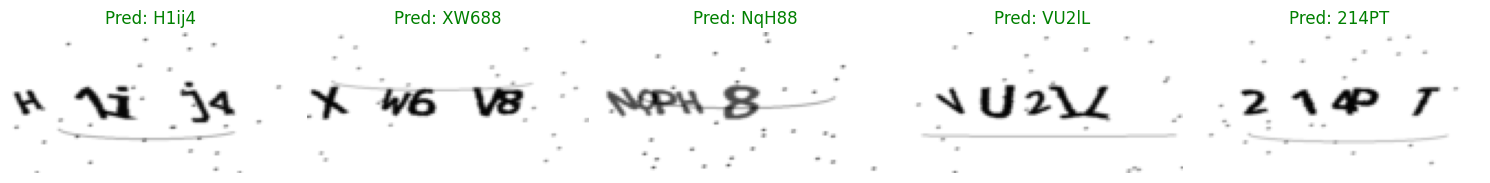

In [38]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

model = CaptchaCNN()
model.load_state_dict(torch.load("best_captcha_model.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize((64, 128))
])

alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
seq_length = 5

def decode_prediction(output, alphabet, seq_length):
    output = output.view(seq_length, len(alphabet))
    predicted_chars = []
    for pos_probs in output:
        char_idx = pos_probs.argmax().item()
        predicted_chars.append(alphabet[char_idx])
    return ''.join(predicted_chars)

captcha_dataset = CaptchaDataset("/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset", transform=transform)
sample_indices = [0, 1, 2, 3, 4]

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    image, _ = captcha_dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        prediction = decode_prediction(output.squeeze(), alphabet, seq_length)

    plt.subplot(1, len(sample_indices), i + 1)
    plt.imshow(image.cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {prediction}", color="green")
    plt.axis("off")

plt.tight_layout()
plt.show()